In [31]:
from collections import ChainMap
from shutil import copy
import os
import pandas as pd
from functools import reduce
import operator
import numpy as np
import matplotlib.pyplot as plt
import bokeh
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from ipywidgets import interact, interact_manual
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import show
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB



complaints_path = r'C:\Users\sheri\Documents\GitHub\chicago-police-data\data\unified_data\fully-unified-data\complaints'
assignment_dir = r'C:\Users\sheri\Documents\GitHub\assignment-7-Sherifalaa'

def generate_paths_complaints_data(base, file_cats):
    comp_fnames = [base.format(i) for i in file_cats]
    return comp_fnames

def get_key(my_dict, val): 
    for key, value in my_dict.items(): 
         if val == value: 
            return key
#https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/
file_names = []
def copy_files_to_dir(paths_dict = {}, work_dir = assignment_dir):
    for fnames in paths_dict.values():
        for fname in fnames:
            file_names.append(fname)
            file = os.path.join(work_dir, fname)
            if os.path.exists(file) == False:
                file = os.path.join(get_key(paths_dict,fnames), fname)
                copy(file, work_dir)

#https://stackoverflow.com/questions/123198/how-do-i-copy-a-file-in-python
#https://stackoverflow.com/questions/7518067/python-ioerror-errno-13-permission-denied-when-im-copying-file

def read_pd(fnames, path = assignment_dir):
    pd_cpd_data = [pd.read_csv(i) for i in [os.path.join(path, j) for j in fnames]]
    return pd_cpd_data

def merge_multiple(files, key = 'cr_id'):
    multiple_merged = reduce(lambda  left,right: pd.merge(left,right,on = key, how='inner'), files)
    return multiple_merged

def merge_two_dfs(files, lkey, rkey = "CODE", old_col_name = '' , new_col_name = '', double = False):
    for i in range(len(lkey)): 
        two_merged = pd.merge(files[0], files[1], how='left', left_on = lkey[i], right_on = rkey)
        if i == 0 & double == True:
            two_merged = two_merged.rename(columns={old_col_name: new_col_name})
    return two_merged

def clean_col_names_and_NAs(df, reps = {"xrep" : "_acc", "yrep": "_inv"}, change_colnames = None, drop_how = 'all', axis = 1):
    #handle _x and _y
    oldnames = []
    newnames = []
    if not reps is None:
        for i in list(df.columns.values):
            if i[-2:] == "_x":
                oldnames.append(i)
                newnames.append(i[:-2] + reps["xrep"])
            if i[-2:] == "_y":
                oldnames.append(i)
                newnames.append(i[:-2] + reps["yrep"])
        df = df.rename(columns=dict(zip(oldnames, newnames)))
    if not change_colnames is None:
        df = df.rename(columns=dict(zip(change_colnames[0], change_colnames[1])))
    #handle empty columns
    df = df.dropna(axis=axis, how=drop_how)
    return df

def subset_data(df, grouping_variable, categories = None, variables = None):
    if not variables is None:
        df = df[variables]
    if not categories is None:
        df = df.loc[df[grouping_variable].isin(categories)]
    return df

def recode_binary(df, bin_var, dummy_name, recode_dict = {}):
    for i in recode_dict:
        df.loc[df[bin_var] == i, dummy_name] = recode_dict[i] 
        #https://stackoverflow.com/questions/49161120/pandas-python-set-value-of-one-column-based-on-value-in-another-column
    return df

def recode_mult_cat(df, cat_var):
    unique_cat = df[cat_var].unique()
    unique_cat = unique_cat.tolist()
    #https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
    enc = preprocessing.OneHotEncoder(categories=[unique_cat])
    enc.fit(df[cat_var].values.reshape(-1, 1))
    encoded_array = enc.transform(df[cat_var].values.reshape(-1, 1)).toarray()
    #https://stackoverflow.com/questions/47957151/error-expected-2d-array-got-1d-array-instead-using-onehotencoder
    encoded_list = encoded_array.tolist()
    races = pd.DataFrame.from_records(encoded_list)
    df = df.join(races)
    df = df.rename(columns=dict(zip(list(range(len(unique_cat))), unique_cat)))
    return df

def summarize_model_data(df, label = 'final_finding'):
    describe = df.describe()
    value_counts = df[label].value_counts()
    hists = df.hist(figsize=(10,9), ec="k")
    plt.tight_layout()
    plt.show()
    scatters = sns.pairplot(df, hue=label)
    return describe, value_counts, hists, scatters

def class_model(df, label):
    X = df.drop(label, axis=1)
    Y = df['final_finding']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=301)
    model = SVC(gamma='auto')
    model.fit(X_train, Y_train)
    predict = model.predict(X_test)
    pred = pd.DataFrame({'predictions': predict})
    pred_value_counts = pred['predictions'].value_counts()
    acc_score = accuracy_score(Y_test, predict)
    conf_matrix = confusion_matrix(Y_test, predict)
    class_report = classification_report(Y_test, predict)
    models = [('Dec Tree', DecisionTreeClassifier()), 
              ('Lin Disc', LinearDiscriminantAnalysis()), ('Gauss', GaussianNB()), 
              ('SVC', SVC(gamma='auto'))]
    results = []
    for name, model in models:
        kf = StratifiedKFold(n_splits=10, random_state=123)
        res = cross_val_score(model, X_train, Y_train, cv=kf, scoring='accuracy')
        res_mean = round(res.mean(), 4)
        res_std  = round(res.std(), 4)
        results.append((name, res_mean, res_std))
    results_df = pd.DataFrame(results, columns=['Method', 'Mean', 'SD'])
    return pred_value_counts, acc_score, conf_matrix, class_report, results_df
#the common part of the three percentages inquiries#
def get_groups_perc(df, groups, agg_col):
    grouped_counts = df.groupby(groups).agg({agg_col: 'count'})
    grouped_perc = grouped_counts.apply(lambda x:100 * x / float(x.sum()))
    return grouped_perc

def prep_bar_data(groups = ["final_finding", "race_vic", "gender_vic"], agg_col = "final_finding", interesting_group = 'SU'):
    grouped_data = get_groups_perc(global_df, groups = groups, agg_col = agg_col)
    grouped_data = grouped_data.rename(columns={agg_col:'percentage'})
    int_grp_data = grouped_data.loc[interesting_group]
    int_grp_data = int_grp_data.reset_index()
    int_grp_data['int_percentage'] = round(100*(int_grp_data['percentage']/int_grp_data['percentage'].sum()), 2)
    int_grp_data = int_grp_data.sort_values(by=['int_percentage'])
    return int_grp_data

def get_merged_df(base_fname = "complaints-{}_2000-2016_2016-11.csv",
         file_cats = ['accused', 'victims', 'investigators'],
        interesting_vars = ['cr_id','complaint_category','recommended_discipline','final_discipline','recommended_finding',
                            'final_finding','UID_acc', 'old_UID_acc','link_UID_acc','gender_vic','age','race_vic',
                            'appointed_date_vic','current_star','current_rank_vic','current_unit_vic','CODE','ACTION_TAKEN',
                            'gender_acc','race_acc','birth_year','current_age','current_status','appointed_date_acc',
                            'current_rank_acc','current_unit_acc','unit_description','resignation_date','UID','old_UID',
                            'link_UID']):
    discpline_dict = {r'C:\Users\sheri\Documents\GitHub\chicago-police-data\data\context_data':
                      ['discipline_penalty_codes.csv']}
    roster_dict =    {r'C:\Users\sheri\Documents\GitHub\chicago-police-data\data\unified_data\roster':
                      ['roster_1936-2017_2017-04.csv']}
    comp_fnames = generate_paths_complaints_data(base_fname, file_cats)
    comp_dict = {complaints_path: comp_fnames}
    all_dict = dict(ChainMap(roster_dict, discpline_dict, comp_dict))#(comp_dict,roster_dict, discpline_dict)
    copy_files_to_dir(all_dict)
    all_pd_files = read_pd(file_names)
    comp_pd_files = all_pd_files[0:len(file_cats)]
    discpline_pd_file = all_pd_files[len(file_cats)]
    roster_pd_file = all_pd_files[-1]
    comp_merged = merge_multiple(comp_pd_files)
    all_merged = merge_two_dfs(files = [comp_merged, discpline_pd_file], old_col_name = "ACTION_TAKEN", 
                           new_col_name = "recommended_action",lkey = ['recommended_discipline', 'final_discipline'],
                           double = True)
    all_merged = clean_col_names_and_NAs(all_merged)
    all_merged = merge_two_dfs(files = [all_merged, roster_pd_file], lkey = ['UID_acc'], rkey = 'UID')
    #merge rosters
    all_merged = clean_col_names_and_NAs(all_merged, {"xrep" : "_vic", "yrep": "_acc"})
    all_merged = subset_data(all_merged, interesting_vars)
    return all_merged
global_df = get_merged_df()
grpd_data = prep_bar_data()

In [21]:
#Explore the split of the victims by race (and gender)

def plot_bar(df = grpd_data, group_var = 'race_vic', value_var = 'int_percentage'):
    p = figure(x_range=df[group_var], plot_height=250, title="Percent sustained by " + group_var)
    p.vbar(x=df[group_var], top=df[value_var], width=0.9)
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    #plot.add_layout(labels)
    show(p)

genders = grpd_data['gender_vic'].unique()
@interact(By_Gender=True, Gender = genders)
def checkbox(By_Gender=True, Gender = "MALE"):
    if By_Gender == True:
        grpd_data = prep_bar_data()
        filtered_df = grpd_data[grpd_data['gender_vic'] == Gender]
        plot_bar(filtered_df)  
    else:
        grpd_data = prep_bar_data(groups = ["final_finding", "race_vic"])
        plot_bar(grpd_data)

interactive(children=(Checkbox(value=True, description='By_Gender'), Dropdown(description='Gender', index=1, o…

C:\Users\sheri\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sheri\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


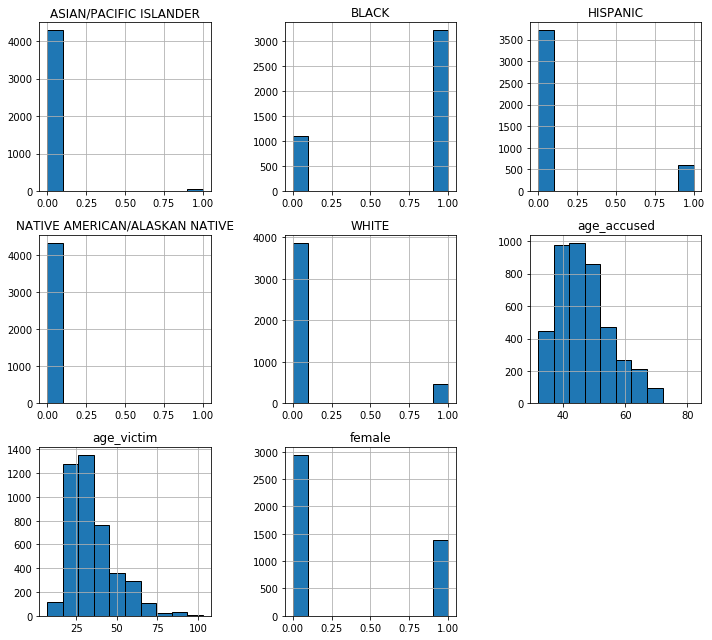

C:\Users\sheri\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\sheri\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\sheri\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\sheri\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\sheri\Anaconda3\lib\si

        age_victim  age_accused       female        BLACK        WHITE  \
count  4325.000000  4325.000000  4325.000000  4325.000000  4325.000000   
mean     34.886243    46.402312     0.320925     0.743584     0.105434   
std      13.719875     8.435778     0.466886     0.436705     0.307147   
min       7.000000    32.000000     0.000000     0.000000     0.000000   
25%      25.000000    40.000000     0.000000     0.000000     0.000000   
50%      31.000000    46.000000     0.000000     1.000000     0.000000   
75%      41.000000    51.000000     1.000000     1.000000     0.000000   
max     103.000000    82.000000     1.000000     1.000000     1.000000   

          HISPANIC  ASIAN/PACIFIC ISLANDER  NATIVE AMERICAN/ALASKAN NATIVE  
count  4325.000000             4325.000000                     4325.000000  
mean      0.141272                0.009480                        0.000231  
std       0.348342                0.096913                        0.015206  
min       0.000000       

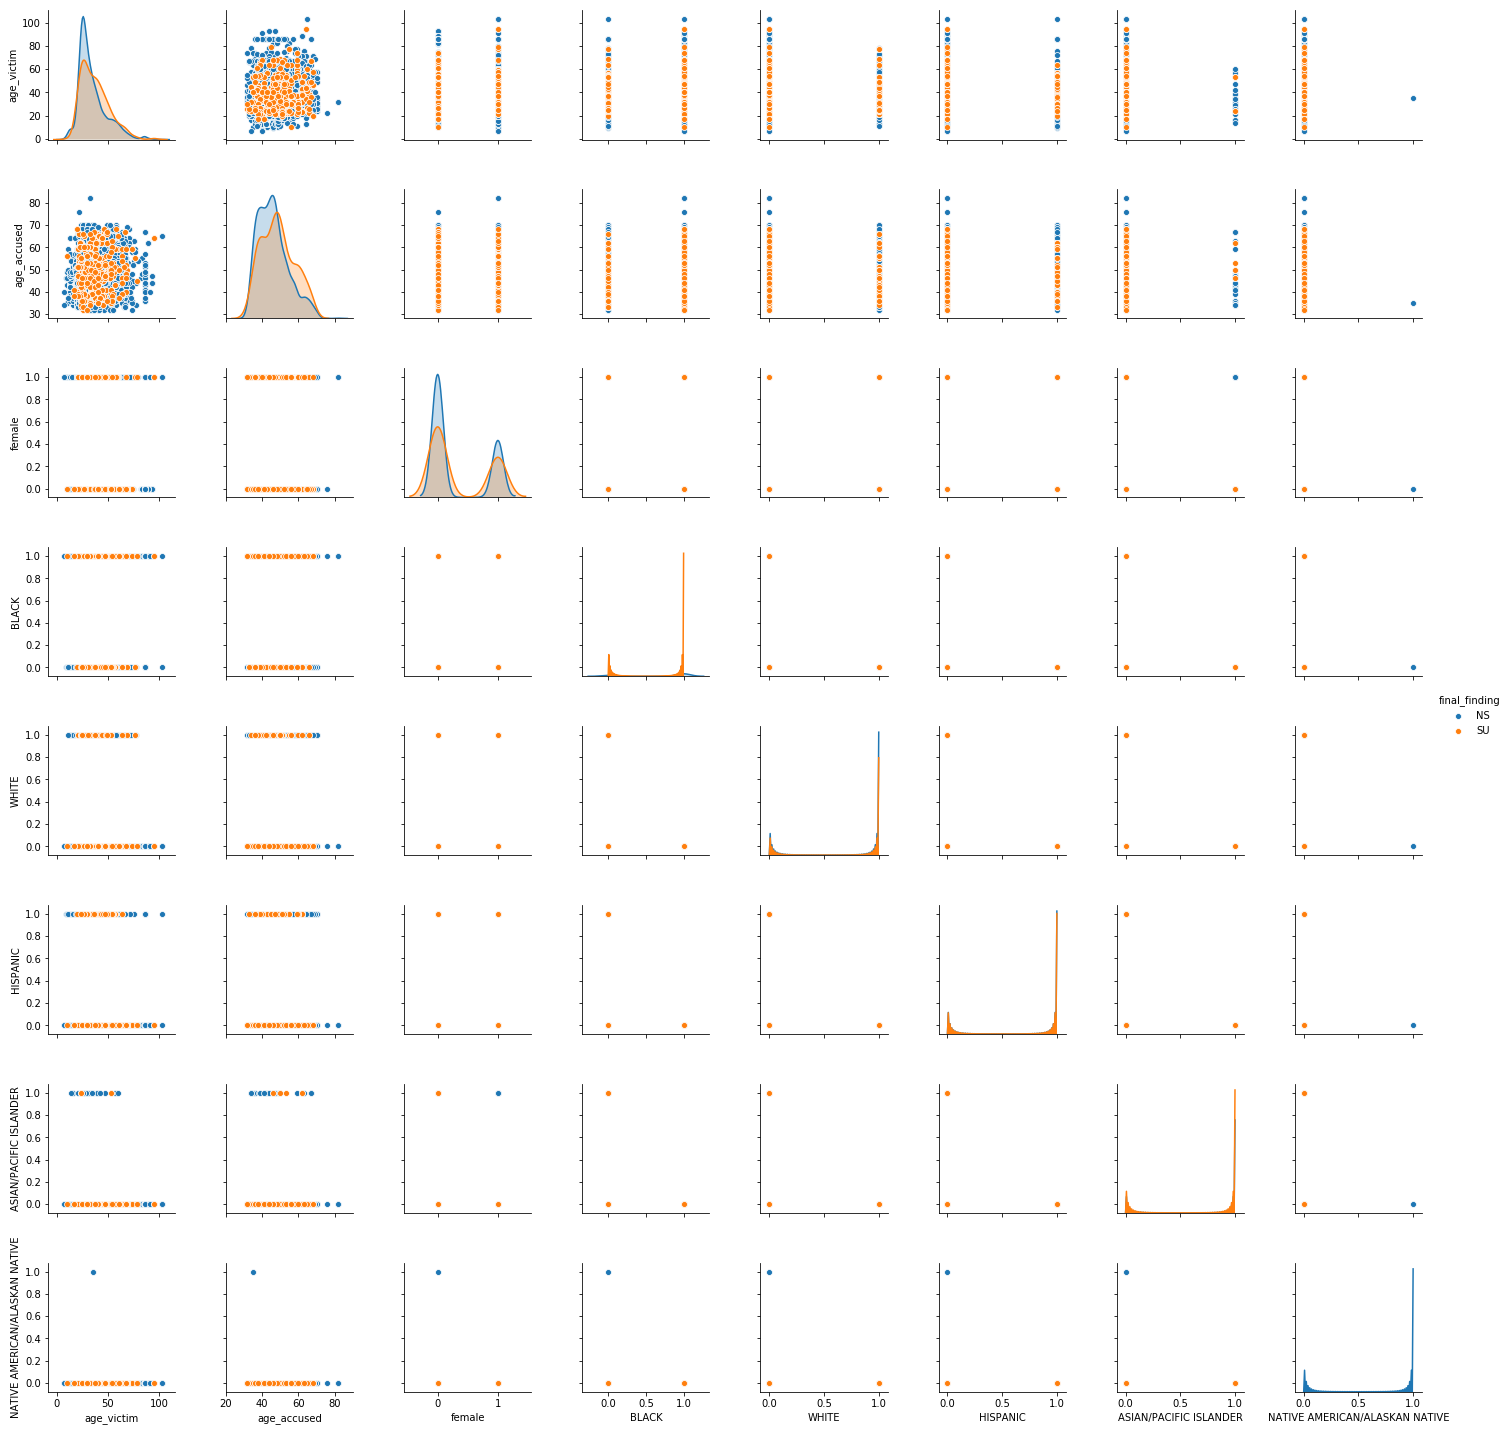

In [42]:
#data prep
def get_model_data(df = get_merged_df(), model_vars = ['final_finding','gender_vic','age','race_vic','current_age']):
    model_df = subset_data(df, None, None, variables = model_vars)
    model_df = recode_binary(model_df, 'gender_vic', 'female', recode_dict = {'MALE': 0, 'FEMALE': 1})
    model_df = clean_col_names_and_NAs(model_df, reps = None, change_colnames = [['age', 'current_age'],['age_victim', 'age_accused']],
                            drop_how = 'any', axis = 0)    
    #recode_cat
    model_df = recode_mult_cat(model_df, 'race_vic')
    model_df = model_df.drop(columns=['gender_vic', 'race_vic'])#drop old race and old gender
#exclude categories other than SU and NS
    model_df = subset_data(model_df, 'final_finding', categories = ['SU', "NS"])
    model_df = clean_col_names_and_NAs(model_df, reps = None, drop_how = 'any', axis = 0)
    return model_df
def main_reporting(report = 'all'):
    model_df = get_model_data()
    describe, value_counts, hists, scatters = summarize_model_data(model_df)
    pred_value_counts, acc_score, conf_matrix, class_report, methods_performance = class_model(model_df, 'final_finding')
    summary_outputs = [describe, value_counts]
    model_outputs = [pred_value_counts, acc_score, conf_matrix, class_report, methods_performance.set_index('Method')]
    all_outputs = summary_outputs + model_outputs
    if report == 'summary':
        for output in summary_outputs:
            print(output)
    if report == 'model':
        for output in model_outputs:
            print(output)
    else:
        for output in all_outputs:
            print(str(output))
main_reporting()
#describe, value_counts, hists, scatters, pred_value_counts, acc_score, conf_matrix, class_report, methods_performance = main_reporting()

In [44]:
describe

,age_victim,age_accused,female,BLACK,WHITE,HISPANIC,ASIAN/PACIFIC ISLANDER,NATIVE AMERICAN/ALASKAN NATIVE
count,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000
mean,34.886243,46.402312,0.320925,0.743584,0.105434,0.141272,0.009480,0.000231
std,13.719875,8.435778,0.466886,0.436705,0.307147,0.348342,0.096913,0.015206
min,7.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,46.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,41.000000,51.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,103.000000,82.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
value_counts

NS    3914
SU     411
Name: final_finding, dtype: int64

In [46]:
pred_value_counts

NS    863
SU      2
Name: predictions, dtype: int64

In [47]:
acc_score

0.915606936416185

In [48]:
conf_matrix

array([[790,   0],
       [ 73,   2]], dtype=int64)

In [50]:
print(class_report)

              precision    recall  f1-score   support

          NS       0.92      1.00      0.96       790
          SU       1.00      0.03      0.05        75

   micro avg       0.92      0.92      0.92       865
   macro avg       0.96      0.51      0.50       865
weighted avg       0.92      0.92      0.88       865



In [51]:
methods_performance.set_index('Method')

,Mean,SD
Method,,
Dec Tree,0.8884,0.0136
Lin Disc,0.9029,0.0012
Gauss,0.2105,0.2288
SVC,0.9040,0.0033


End your code with a few lines discussing what you found. Did your model do a good job of predicting labels? 
What did you anticipate from step 2 and 4 above? What accuracy measure did you use to evaluate the model results, and why?:

_Write-UP______________________________________________________________________

First, the research question tackled by this code is: To what extent can we predict the sustainability of the complaints against police officers given demographic characteristics of victims and accused officers?

The predictors were selected by a forward selection method, first it was only the ages of the victim and the accused, the after adding the race of the victim using the one hot encoder to transform it to dummy variables, the accuracy increased significantly, from 87% to almost 91%. Then after adding the gender of the victim it increased by a slight percentage to reach 91.6%. Thus, this accuracy level was satisfactory enough to proceed building the model with these predictors, despite having colinearity between some of them

The findings suggest that the gender,rave and age of the victims as well as the age of the accused police officer are good enough predictors for whether the victims' complaints against the accused officers will be sustained or not. The model originally used, Support Vector Machines (SVC) was the most accurate in predicting the sustainability of the complaints with an accuracy score of 91.6%

Step 2: the summary statistics and graphs showed that victim's race is an important element in the sustainability of the complaints. Moreover, the histograms showed a positive skewed distributions in both the age of the accused officers and the victims. Finally, the gender role is intuitively insightful into such an issue which was displayed in the bar graph by gender.

Step 4: Out of the 4 models used (Decision trees, Linear Discriminatory Analysis, Gaussian and SVC) three displayed great accuracy measures and the only onw ith poor performance was the Gaussian. The top 2 methods both in terms of the mean accuracy of the stratified K-folds and the standard deviation as a measure of robustness were: SVC and Linear Discriminatory Analysis and both are almost indiffernt, SVC is slightly more accurate on average and Linear Discriminatory Analysis is slightly more robust. Both differences are quite insignificant

Consequently, Steps 2 and 4 gave an impression that the model's predictibility will be satisfactory enough to answer the research question at hand

The accuracy measure used is percentage of accuracy, (number of true positive and true negatives divided by the total number of predictions, the reason to use accuracy here is that we care equally about our predictibility of sustained and unsustained complaints

N.B. I reprinted my model outputs again just to make it easier to have a second look on them for the TA correcting my code